In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import matplotlib.pyplot as plt

import copy
from PIL import Image

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [3]:
torch.cuda.get_device_name()

'Quadro P5000'

### IMAGE LOADERS

In [4]:
imsize = 512

loader = torchvision.transforms.Compose([
    torchvision.transforms.Resize(imsize),
    torchvision.transforms.ToTensor()
])

unloader = torchvision.transforms.ToPILImage()

In [5]:
style_img = ("../storage/data/AS_storage/Styletransfer/picasso.jpg")
content_img = ("../storage/data/AS_storage/Styletransfer/huron.jpg")

In [6]:
def image_loader(image_path):
    image = Image.open(image_path)
    image = loader(image).unsqueeze(0)
    return image.to(device)

In [7]:
style_img = image_loader(style_img)
content_img = image_loader(content_img)

In [8]:
style_img.shape, content_img.shape

(torch.Size([1, 3, 512, 512]), torch.Size([1, 3, 512, 512]))

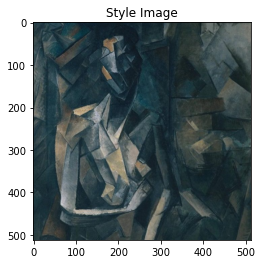

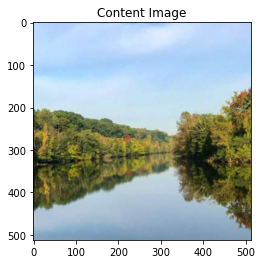

In [9]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
imshow(style_img, title="Style Image")
plt.figure()
imshow(content_img, title="Content Image")

### LOSS FUNCTIONS

In [10]:
# we 'detach' the target content from the tree used
# to dynamically compute the gradient: this is a stated value,
# not a variable. Otherwise the forward method of the criterion
# will throw an error.
        
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = torch.nn.functional.mse_loss(input, self.target)
        return input

In [11]:
def gram_matrix(input):
    a,b,c,d = input.size()
    features = input.view(a*b, c*d)
    G = torch.mm(features, features.t())
    return G.div(a*b*c*d)

In [12]:
class StyleLoss(nn.Module):
    def __init__(self, target_features):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_features).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = torch.nn.functional.mse_loss(G, self.target)
        return input

### MODEL

In [13]:
cnn = torchvision.models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
# create a module to normalize input image so we can easily put it in a
# nn.Sequential
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1,1,1)
        self.std = torch.tensor(std).view(-1,1,1)
        
    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

### RUN MODEL

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img,
                            num_steps=300, style_weight=1000000, content_weight=1)
plt.figure()
imshow(output, title='Output Image')

In [ ]:
output.shape

In [ ]:
torchvision.utils.save_image(output, fp="../storage/data/AS_storage/Styletransfer/NewDog.jpg", nrow=1)